#### Start with installing the snowflake connector

In [1]:
!pip install snowflake-connector-python[pandas]

     |████████████████████████████████| 13.2 MB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 192 kB 68.1 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 61.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 63.2 MB/s eta 0:00:01
     |████████████████████████████████| 20.7 MB 47.7 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 6.7 MB/s  eta 0:00:01
     |████████████████████████████████| 136 kB 46.7 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 47.3 MB/s eta 0:00:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 4.0.0
    Uninstalling pyarrow-4.0.0:
      Successfully uninstalled pyarrow-4.0.0


##### Import Packages Needed

In [101]:
import pandas as pd
from snowflake.connector import pandas_tools as sfpd
import snowflake.connector
import toml
import numpy as np
import datetime as dt

Connect to the Environment

In [102]:
env = toml.load('config.toml')
conn = snowflake.connector.connect(
                user= env['trial'].get('user'),
                password= env['trial'].get('password'),
                account= env['trial'].get('account'),
                warehouse=env['trial'].get('warehouse'),
                database=env['trial'].get('database'),
                schema=env['trial'].get('schema')
                )

In [104]:
cur = conn.cursor()
sql = "select * from abalone_test;"
cur.execute(sql)
abalone_test = cur.fetch_pandas_all()

In [117]:
tbl = 'ABALONE_OBSDATES'
sql = f"drop table if exists {tbl};"
cur.execute(sql);

In [108]:
abalone_test.head()

,SEX,LENGTH,DIAMETER,HEIGHT,WHOLE_WEIGHT,SHUCKED_WEIGHT,VISCERA_WEIGHT,SHELL_WEIGHT,RINGS
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [109]:
# the limit ensures that rest of the logic is edge-case safe.
sql=f'''select distinct postal_code from 
        "WEATHERSOURCE_PARTNER_WEATHER_SOURCE_SAMPLE_DAILY_CAPITALS_CA_EU_US"."PUBLIC"."HISTORY_DAY"
        where date_valid_std = current_date()-7
        limit {len(abalone_test)}; '''

In [110]:
cur.execute(sql)
postal_codes = cur.fetch_pandas_all()

In [111]:
abalone_test['POSTAL_CODE'] = [postal_codes.sample(1)['POSTAL_CODE'].item() 
                               for i in range(0, len(abalone_test))]

In [112]:
abalone_test.POSTAL_CODE.describe() #check if it works out ok!

count      4177
unique       64
top       05601
freq         82
Name: POSTAL_CODE, dtype: object

In [113]:
abalone_test['OBS_DATE']=dt.date.today() - dt.timedelta(7) # get today and go back 7 days

In [114]:
abalone_test.head()

,SEX,LENGTH,DIAMETER,HEIGHT,WHOLE_WEIGHT,SHUCKED_WEIGHT,VISCERA_WEIGHT,SHELL_WEIGHT,RINGS,POSTAL_CODE,OBS_DATE
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,94203,2021-05-09
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,89701,2021-05-09
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,62701,2021-05-09
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,G1R,2021-05-09
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,06101,2021-05-09


In [119]:
sql = f"create table {tbl} like ABALONE_TEST;"
cur.execute(sql);

In [120]:
sql = f"alter table {tbl}  add column POSTAL_CODE varchar(16), column OBS_DATE date;"
cur.execute(sql);

In [121]:
try:
    success, nchunks, nrows, _ = sfpd.write_pandas(conn, abalone_test,tbl)
    print(f"INFO: Write Pandas method reported Success = {success}, with a total number of {nrows} rows written to the table {tbl}")
except RunTimeError as e:
    print(e) 

INFO: Write Pandas method reported Success = True, with a total number of 4177 rows written to the table ABALONE_OBSDATES


In [122]:
join_sql = '''select OBS_DATE, a.POSTAL_CODE, SEX, LENGTH, DIAMETER, HEIGHT,
        WHOLE_WEIGHT, SHUCKED_WEIGHT,VISCERA_WEIGHT, SHELL_WEIGHT, RINGS, 
        MIN_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_AIR_2M_F,MAX_TEMPERATURE_AIR_2M_F,
        MIN_HUMIDITY_RELATIVE_2M_PCT,AVG_HUMIDITY_RELATIVE_2M_PCT,MAX_HUMIDITY_RELATIVE_2M_PCT
        from "SGDB"."PUBLIC"."ABALONE_OBSDATES" as a
        inner join "WEATHERSOURCE_PARTNER_WEATHER_SOURCE_SAMPLE_DAILY_CAPITALS_CA_EU_US"."PUBLIC"."HISTORY_DAY" as b on b.date_valid_std = a.obs_date
        and a.POSTAL_CODE = b. POSTAL_CODE;'''
cur.execute(join_sql)
ab_temp_humidity_df = cur.fetch_pandas_all()

In [123]:
ab_temp_humidity_df.head()

,OBS_DATE,POSTAL_CODE,SEX,LENGTH,DIAMETER,HEIGHT,WHOLE_WEIGHT,SHUCKED_WEIGHT,VISCERA_WEIGHT,SHELL_WEIGHT,RINGS,MIN_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_AIR_2M_F,MAX_TEMPERATURE_AIR_2M_F,MIN_HUMIDITY_RELATIVE_2M_PCT,AVG_HUMIDITY_RELATIVE_2M_PCT,MAX_HUMIDITY_RELATIVE_2M_PCT
0,2021-05-09,A1C,M,0.370,0.265,0.075,0.2140,0.0900,0.0510,0.070,6,37.5,42.5,47.6,78,88,98
1,2021-05-09,A1C,M,0.595,0.455,0.195,1.3305,0.4595,0.3235,0.345,19,37.5,42.5,47.6,78,88,98
2,2021-05-09,A1C,F,0.620,0.470,0.200,1.2255,0.3810,0.2700,0.435,23,37.5,42.5,47.6,78,88,98
3,2021-05-09,A1C,F,0.580,0.455,0.155,0.8365,0.3150,0.1385,0.320,18,37.5,42.5,47.6,78,88,98
4,2021-05-09,A1C,M,0.575,0.455,0.145,1.1650,0.5810,0.2275,0.300,14,37.5,42.5,47.6,78,88,98


,count,mean,std,min,25%,50%,75%,max
AVG_HUMIDITY_RELATIVE_2M_PCT,4177.0,67.642566,16.921043,17.0,59.0,71.0,81.0,93.0
MAX_HUMIDITY_RELATIVE_2M_PCT,4177.0,86.954752,14.899861,31.0,85.0,92.0,95.0,100.0


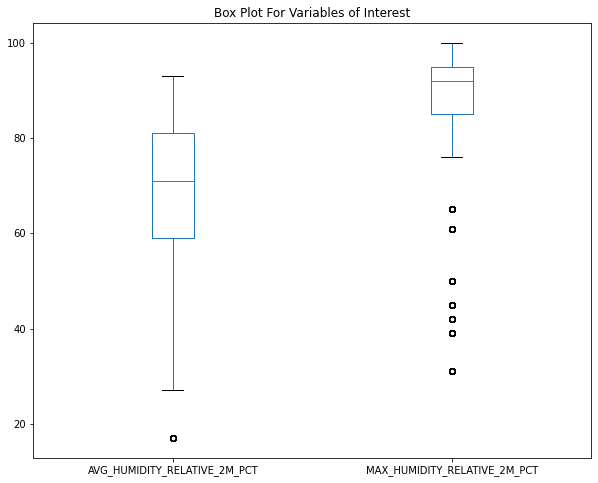

In [148]:
interest_vars = ['AVG_HUMIDITY_RELATIVE_2M_PCT','MAX_HUMIDITY_RELATIVE_2M_PCT']
ab_temp_humidity_df[interest_vars].plot(kind='box',figsize=(10,8), title='Box Plot For Variables of Interest');
pd.DataFrame(ab_temp_humidity_df[interest_vars].describe()).T

In [149]:
cur.close()
conn.close()